## Setup

In [1]:
%matplotlib inline

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [3]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [4]:
sys.argv = ['']
args = vars(ap.parse_args())

In [5]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [18]:
DATASET = "adult_race"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 2
ATTACK = "mia2"

In [19]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# cpp_metrics = defaultdict(list) 
# cpp_mia_metrics = defaultdict(list)

# pr_orig_metrics = defaultdict(list) 
# ro_metrics = defaultdict(list) 

In [20]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [21]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc_helpers\data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})


In [22]:
df, _ = dataset_orig.convert_to_dataframe()

In [23]:
dataset_orig.features.shape

(48842, 18)

In [24]:
privileged_groups

[{'race': 1}]

In [25]:
sens_attr

'race'

In [26]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [27]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

## Run Mitigating Algorithms

### Setup for MIA2

In [28]:
seed = 1234
np.random.seed(seed)

In [29]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [30]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [31]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [32]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [33]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [34]:
# target_dataset = None
# reference_dataset = None

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [37]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
GET UNIQUE INDICES REFERENCE
Number of train points: 5861
Number of test points: 5861
Number of population points: 14652
CREATE BINARY LABEL DATASET
CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  5004.0 857.0
base_pos unpriv:  0.14352392065344224
base_pos priv:  0.2519984012789768
DIFFERENCE IS GOOD
base_pos unpriv:  0.14352392065344224
base_pos priv:  0.2519984012789768
no bias type specified
#### Training Dataset shape
(5861, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11'

DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.00000              0.0          0.00000         0.707107   
1      1.0  0.00000              0.0          0.00000         0.000000   
2      1.0  0.57735              0.0          0.00000         0.577350   
3      1.0  0.57735              0.0          0.57735         0.000000   
4      1.0  0.57735              0.0          0.00000         0.000000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735              0.0          0.00000         0.000000   
5857   1.0  0.57735              0.0          0.00000         0.000000   
5858   0.0  0.00000              0.0          0.00000         0.707107   
5859   1.0  0.57735              0.0          0.00000         0.000000   
5860   1.0  0.57735              0.0          0.00000         0.000000   

      Age (decade)=40  Age (decade)=50  Age (decade)=60  Age (decade)=>=70  \
0 

[INFO]: training decision tree
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Best thresh:  [0.24889605]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: [0.30910451]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 734, Test = 698
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.03
  Positive predictive value: 0.58
  Optimal thershold: [0.02702867]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 123, Test = 129
  AUC: 0.44
  Privacy Risk: 0.50
  Accuracy: 0.52
  Train Accuracy (TPR): 0.02
  Test Accuracy (TNR): 0.98
  Attacker advantage: 0.11

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.22314355]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: [0.4567584]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 733, Test = 715
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.02
  Positive predictive value: 0.52
  Optimal thershold: [0.02777956]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 123, Test = 127
  AUC: 0.54
  Privacy Risk: 0.55
  Accuracy: 0.54
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.10
  Positive predictive value: 0.53
  Optimal thers

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.57735              0.0              0.0         0.577350   
1       1.0  0.00000              0.0              0.0         0.000000   
2       1.0  0.00000              0.0              0.0         0.707107   
3       1.0  0.57735              0.0              0.0         0.000000   
4       1.0  0.57735              0.0              0.0         0.000000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735              0.0              0.0         0.000000   
14648   1.0  0.00000              0.0              0.0         0.000000   
14649   1.0  0.57735              0.0              0.0         0.000000   
14650   1.0  0.57735              0.0              0.0         0.000000   
14651   1.0  0.57735              0.0              0.0         0.577350   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.40
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: [0.00809392]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 733, Test = 715
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: [0.00655891]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 123, Test = 127
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.1127408

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0          0.00000          0.00000   
1      1.0  0.57735              0.0          0.00000          0.00000   
2      1.0  0.00000              0.0          0.00000          0.00000   
3      1.0  0.00000              0.0          0.00000          0.00000   
4      1.0  0.57735              0.0          0.00000          0.00000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.00000              0.0          0.00000          0.00000   
5857   1.0  0.57735              0.0          0.00000          0.00000   
5858   0.0  0.57735              0.0          0.00000          0.00000   
5859   1.0  0.57735              0.0          0.00000          0.57735   
5860   1.0  0.57735              0.0          0.57735          0.00000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.57735              0.0         0.000000          0.57735   
1       1.0  0.00000              0.0         0.707107          0.00000   
2       0.0  0.00000              0.0         0.707107          0.00000   
3       0.0  0.00000              0.0         0.707107          0.00000   
4       1.0  0.57735              0.0         0.000000          0.00000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735              0.0         0.577350          0.00000   
14648   1.0  0.57735              0.0         0.000000          0.00000   
14649   1.0  0.57735              0.0         0.000000          0.00000   
14650   1.0  0.57735              0.0         0.000000          0.00000   
14651   0.0  0.00000              0.0         0.707107          0.00000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.09
  Test Accuracy (TNR): 0.91
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.00043752]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 668, Test = 696
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.21
  Test Accuracy (TNR): 0.81
  Attacker advantage: 0.02
  Positive predictive value: 0.52
  Optimal thershold: [0.00079058]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 129, Test = 114
  AUC: 0.46
  Privacy Risk: 0.53
  Accuracy: 0.56
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.11
  Positive predictive value: 0.55
  Optimal thershold: [0.1792853

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0          0.57735          0.00000   
1      1.0  0.57735              0.0          0.00000          0.57735   
2      0.0  0.00000              0.0          0.00000          0.00000   
3      1.0  0.00000              0.0          0.00000          0.00000   
4      1.0  0.57735              0.0          0.57735          0.00000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.00000              0.0          0.00000          0.00000   
5857   0.0  0.00000              0.0          0.00000          0.00000   
5858   0.0  0.57735              0.0          0.00000          0.00000   
5859   1.0  0.57735              0.0          0.00000          0.00000   
5860   1.0  0.57735              0.0          0.57735          0.00000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.57735              0.0         0.000000         0.577350   
1       1.0  0.57735              0.0         0.000000         0.577350   
2       1.0  0.00000              0.0         0.000000         0.707107   
3       0.0  0.57735              0.0         0.577350         0.000000   
4       1.0  0.00000              0.0         0.000000         0.000000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735              0.0         0.000000         0.000000   
14648   1.0  0.00000              0.0         0.707107         0.000000   
14649   1.0  0.00000              0.0         0.000000         0.000000   
14650   1.0  0.57735              0.0         0.000000         0.000000   
14651   1.0  0.00000              0.0         0.000000         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.09
  Test Accuracy (TNR): 0.91
  Attacker advantage: 0.01
  Positive predictive value: 0.52
  Optimal thershold: [0.00237866]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 712, Test = 757
  AUC: 0.51
  Privacy Risk: 0.50
  Accuracy: 0.52
  Train Accuracy (TPR): 0.06
  Test Accuracy (TNR): 0.95
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: [0.06846204]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 131, Test = 133
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy (TPR): 0.21
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.11
  Positive predictive value: 0.68
  Optimal thershold: [0.0590611

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0         0.000000         0.000000   
1      1.0  0.00000              0.0         0.000000         0.707107   
2      1.0  0.00000              0.0         0.000000         0.707107   
3      1.0  0.00000              0.0         0.707107         0.000000   
4      1.0  0.57735              0.0         0.000000         0.000000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735              0.0         0.000000         0.577350   
5857   1.0  0.57735              0.0         0.000000         0.000000   
5858   1.0  0.57735              0.0         0.577350         0.000000   
5859   1.0  0.00000              0.0         0.000000         0.707107   
5860   1.0  0.00000              0.0         0.000000         0.707107   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.57735              0.0          0.00000          0.00000   
1       1.0  0.57735              0.0          0.00000          0.57735   
2       1.0  0.57735              0.0          0.00000          0.00000   
3       1.0  0.57735              0.0          0.57735          0.00000   
4       1.0  0.57735              0.0          0.00000          0.00000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735              0.0          0.00000          0.00000   
14648   1.0  0.57735              0.0          0.00000          0.00000   
14649   1.0  0.57735              0.0          0.00000          0.57735   
14650   1.0  0.57735              0.0          0.57735          0.00000   
14651   1.0  0.57735              0.0          0.00000          0.00000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.02509957]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 720, Test = 747
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.60
  Attacker advantage: 0.06
  Positive predictive value: 0.53
  Optimal thershold: [0.00512735]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 144, Test = 126
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.53
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.05
  Positive predictive value: 0.56
  Optimal thershold: [0.0476876

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      0.0  0.57735              0.0         0.577350         0.000000   
1      1.0  0.57735              0.0         0.577350         0.000000   
2      1.0  0.57735              0.0         0.000000         0.577350   
3      1.0  0.00000              0.0         0.000000         0.707107   
4      1.0  0.57735              0.0         0.000000         0.000000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735              0.0         0.577350         0.000000   
5857   1.0  0.57735              0.0         0.577350         0.000000   
5858   1.0  0.00000              0.0         0.000000         0.000000   
5859   1.0  0.00000              0.0         0.707107         0.000000   
5860   1.0  0.57735              0.0         0.000000         0.000000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.00000         0.000000              0.0         0.000000   
1       0.0  0.00000         0.000000              0.0         0.707107   
2       1.0  0.00000         0.000000              0.0         0.707107   
3       1.0  0.57735         0.000000              0.0         0.577350   
4       1.0  0.00000         0.000000              0.0         0.000000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.00000         0.000000              0.0         0.000000   
14648   0.0  0.57735         0.000000              0.0         0.577350   
14649   1.0  0.57735         0.000000              0.0         0.000000   
14650   1.0  0.57735         0.000000              0.0         0.000000   
14651   1.0  0.00000         0.707107              0.0         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.84
  Attacker advantage: 0.01
  Positive predictive value: 0.53
  Optimal thershold: [0.0022911]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 705, Test = 726
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.27
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.0025151]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 142, Test = 114
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.61
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.15
  Positive predictive value: 0.68
  Optimal thershold: [0.30540451]

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0         0.000000          0.57735   
1      1.0  0.57735              0.0         0.000000          0.00000   
2      1.0  0.57735              0.0         0.000000          0.00000   
3      1.0  0.57735              0.0         0.000000          0.00000   
4      1.0  0.57735              0.0         0.000000          0.57735   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735              0.0         0.000000          0.57735   
5857   1.0  0.00000              0.0         0.707107          0.00000   
5858   0.0  0.57735              0.0         0.577350          0.00000   
5859   1.0  0.00000              0.0         0.000000          0.00000   
5860   1.0  0.57735              0.0         0.000000          0.57735   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.57735              0.0         0.000000          0.00000   
1       1.0  0.00000              0.0         0.000000          0.00000   
2       1.0  0.00000              0.0         0.000000          0.00000   
3       1.0  0.57735              0.0         0.000000          0.00000   
4       1.0  0.00000              0.0         0.000000          0.00000   
...     ...      ...              ...              ...              ...   
14647   0.0  0.57735              0.0         0.000000          0.00000   
14648   1.0  0.00000              0.0         0.000000          0.00000   
14649   1.0  0.57735              0.0         0.000000          0.00000   
14650   1.0  0.00000              0.0         0.707107          0.00000   
14651   1.0  0.57735              0.0         0.000000          0.57735   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: [0.04357525]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 736, Test = 704
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.05
  Positive predictive value: 0.62
  Optimal thershold: [0.0157018]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 113, Test = 135
  AUC: 0.52
  Privacy Risk: 0.50
  Accuracy: 0.54
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.06
  Positive predictive value: 0.48
  Optimal thershold: [0.06403932

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735         0.000000              0.0         0.000000   
1      1.0  0.00000         0.000000              0.0         0.707107   
2      1.0  0.57735         0.000000              0.0         0.000000   
3      1.0  0.57735         0.000000              0.0         0.577350   
4      1.0  0.00000         0.707107              0.0         0.000000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735         0.000000              0.0         0.000000   
5857   1.0  0.57735         0.000000              0.0         0.000000   
5858   1.0  0.00000         0.000000              0.0         0.000000   
5859   1.0  0.57735         0.000000              0.0         0.577350   
5860   1.0  0.57735         0.000000              0.0         0.000000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       0.0  0.00000         0.000000          0.00000         0.707107   
1       1.0  0.57735         0.577350          0.00000         0.000000   
2       1.0  0.57735         0.000000          0.00000         0.000000   
3       1.0  0.57735         0.000000          0.00000         0.000000   
4       1.0  0.57735         0.000000          0.00000         0.000000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735         0.000000          0.00000         0.000000   
14648   1.0  0.57735         0.000000          0.00000         0.577350   
14649   1.0  0.57735         0.000000          0.00000         0.000000   
14650   1.0  0.57735         0.000000          0.57735         0.000000   
14651   1.0  0.00000         0.707107          0.00000         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: [0.09126021]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 764, Test = 695
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.53
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: [0.02774727]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 121, Test = 128
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.04
  Test Accuracy (TNR): 0.99
  Attacker advantage: 0.08
  Positive predictive value: 0.83
  Optimal thershold: [0.4710508

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0         0.000000          0.00000   
1      1.0  0.57735              0.0         0.000000          0.57735   
2      1.0  0.00000              0.0         0.707107          0.00000   
3      1.0  0.57735              0.0         0.000000          0.57735   
4      1.0  0.00000              0.0         0.707107          0.00000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.00000              0.0         0.707107          0.00000   
5857   1.0  0.00000              0.0         0.707107          0.00000   
5858   1.0  0.57735              0.0         0.000000          0.00000   
5859   1.0  0.57735              0.0         0.000000          0.00000   
5860   0.0  0.57735              0.0         0.000000          0.00000   

      Age (decade)=40  Age (dec

[INFO]: training decision tree
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Best thresh:  [0.23211222]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.32652191]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 745, Test = 707
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: [0.05820939]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 137, Test = 126
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.08

Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.2597533]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.43
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: [0.2006707]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 696, Test = 673
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.50
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.06
  Positive predictive value: 0.54
  Optimal thershold: [0.09531018]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 128, Test = 144
  AUC: 0.55
  Privacy Risk: 0.56
  Accuracy: 0.57
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.12
  Positive predictive value: 0.59
  Optimal thershold: [0.83832919]
)
MIA_Result(
  Name: 

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.00000          0.00000         0.000000         0.000000   
1       1.0  0.57735          0.57735         0.000000         0.000000   
2       1.0  0.00000          0.00000         0.707107         0.000000   
3       1.0  0.57735          0.00000         0.000000         0.577350   
4       0.0  0.00000          0.00000         0.707107         0.000000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.00000          0.00000         0.000000         0.000000   
14648   1.0  0.57735          0.00000         0.000000         0.000000   
14649   1.0  0.00000          0.00000         0.000000         0.707107   
14650   1.0  0.57735          0.00000         0.577350         0.000000   
14651   1.0  0.57735          0.00000         0.000000         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.40
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.02
  Positive predictive value: 0.52
  Optimal thershold: [0.02100361]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 696, Test = 673
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.06
  Positive predictive value: 0.55
  Optimal thershold: [0.02100361]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 128, Test = 144
  AUC: 0.55
  Privacy Risk: 0.56
  Accuracy: 0.57
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.12
  Positive predictive value: 0.59
  Optimal thershold: [0.0904671

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735          0.00000         0.000000         0.000000   
1      1.0  0.00000          0.00000         0.707107         0.000000   
2      1.0  0.00000          0.00000         0.000000         0.707107   
3      0.0  0.57735          0.00000         0.000000         0.000000   
4      1.0  0.57735          0.00000         0.000000         0.000000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735          0.00000         0.577350         0.000000   
5857   1.0  0.57735          0.57735         0.000000         0.000000   
5858   1.0  0.57735          0.00000         0.000000         0.577350   
5859   1.0  0.57735          0.00000         0.000000         0.577350   
5860   1.0  0.57735          0.00000         0.000000         0.000000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.57735          0.00000         0.577350         0.000000   
1       1.0  0.57735          0.57735         0.000000         0.000000   
2       1.0  0.00000          0.00000         0.000000         0.000000   
3       1.0  0.00000          0.00000         0.000000         0.707107   
4       1.0  0.57735          0.00000         0.000000         0.000000   
...     ...      ...              ...              ...              ...   
14647   0.0  0.57735          0.00000         0.000000         0.000000   
14648   0.0  0.57735          0.57735         0.000000         0.000000   
14649   1.0  0.00000          0.00000         0.707107         0.000000   
14650   1.0  0.57735          0.00000         0.000000         0.577350   
14651   1.0  0.57735          0.00000         0.000000         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: [0.02273889]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 691, Test = 760
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.53
  Train Accuracy (TPR): 0.08
  Test Accuracy (TNR): 0.93
  Attacker advantage: 0.04
  Positive predictive value: 0.70
  Optimal thershold: [0.03163139]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 152, Test = 105
  AUC: 0.57
  Privacy Risk: 0.52
  Accuracy: 0.60
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.14
  Positive predictive value: 0.90
  Optimal thershold: [0.0431669

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0         0.577350          0.00000   
1      1.0  0.57735              0.0         0.000000          0.00000   
2      1.0  0.57735              0.0         0.000000          0.00000   
3      1.0  0.57735              0.0         0.577350          0.00000   
4      1.0  0.00000              0.0         0.707107          0.00000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735              0.0         0.000000          0.00000   
5857   1.0  0.57735              0.0         0.000000          0.57735   
5858   0.0  0.57735              0.0         0.577350          0.00000   
5859   1.0  0.57735              0.0         0.000000          0.00000   
5860   1.0  0.57735              0.0         0.000000          0.00000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.57735              0.0          0.57735         0.000000   
1       1.0  0.57735              0.0          0.57735         0.000000   
2       1.0  0.57735              0.0          0.00000         0.577350   
3       1.0  0.57735              0.0          0.57735         0.000000   
4       1.0  0.00000              0.0          0.00000         0.707107   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735              0.0          0.57735         0.000000   
14648   0.0  0.57735              0.0          0.00000         0.577350   
14649   1.0  0.57735              0.0          0.57735         0.000000   
14650   1.0  0.57735              0.0          0.00000         0.000000   
14651   1.0  0.57735              0.0          0.57735         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.01209467]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 693, Test = 689
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.04
  Positive predictive value: 0.62
  Optimal thershold: [0.01578309]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 149, Test = 123
  AUC: 0.53
  Privacy Risk: 0.55
  Accuracy: 0.58
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.09
  Positive predictive value: 0.58
  Optimal thershold: [0.2757824

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0         0.000000         0.577350   
1      0.0  0.57735              0.0         0.000000         0.000000   
2      1.0  0.00000              0.0         0.707107         0.000000   
3      0.0  0.57735              0.0         0.000000         0.577350   
4      1.0  0.57735              0.0         0.000000         0.000000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735              0.0         0.000000         0.000000   
5857   1.0  0.57735              0.0         0.000000         0.577350   
5858   1.0  0.00000              0.0         0.000000         0.707107   
5859   1.0  0.00000              0.0         0.000000         0.000000   
5860   0.0  0.00000              0.0         0.000000         0.707107   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       0.0  0.00000          0.00000              0.0         0.000000   
1       1.0  0.57735          0.00000              0.0         0.577350   
2       0.0  0.57735          0.00000              0.0         0.000000   
3       1.0  0.57735          0.00000              0.0         0.577350   
4       1.0  0.00000          0.00000              0.0         0.000000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735          0.57735              0.0         0.000000   
14648   1.0  0.57735          0.00000              0.0         0.000000   
14649   0.0  0.00000          0.00000              0.0         0.000000   
14650   1.0  0.00000          0.00000              0.0         0.707107   
14651   0.0  0.00000          0.00000              0.0         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: [0.02219456]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 748, Test = 704
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.05
  Positive predictive value: 0.71
  Optimal thershold: [0.00956321]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 145, Test = 117
  AUC: 0.52
  Privacy Risk: 0.55
  Accuracy: 0.58
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.11
  Positive predictive value: 0.59
  Optimal thershold: [0.1879753

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.00000              0.0         0.707107          0.00000   
1      1.0  0.00000              0.0         0.707107          0.00000   
2      1.0  0.00000              0.0         0.000000          0.00000   
3      1.0  0.00000              0.0         0.000000          0.00000   
4      1.0  0.57735              0.0         0.000000          0.57735   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735              0.0         0.000000          0.57735   
5857   0.0  0.00000              0.0         0.707107          0.00000   
5858   1.0  0.57735              0.0         0.000000          0.57735   
5859   1.0  0.57735              0.0         0.000000          0.57735   
5860   0.0  0.00000              0.0         0.707107          0.00000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.57735              0.0          0.57735         0.000000   
1       1.0  0.57735              0.0          0.00000         0.577350   
2       1.0  0.57735              0.0          0.00000         0.577350   
3       1.0  0.57735              0.0          0.57735         0.000000   
4       1.0  0.00000              0.0          0.00000         0.707107   
...     ...      ...              ...              ...              ...   
14647   1.0  0.00000              0.0          0.00000         0.707107   
14648   1.0  0.57735              0.0          0.00000         0.000000   
14649   1.0  0.00000              0.0          0.00000         0.000000   
14650   1.0  0.00000              0.0          0.00000         0.000000   
14651   1.0  0.57735              0.0          0.00000         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.05079032]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 737, Test = 706
  AUC: 0.51
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.02
  Positive predictive value: 0.63
  Optimal thershold: [0.00490689]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 126, Test = 143
  AUC: 0.52
  Privacy Risk: 0.56
  Accuracy: 0.58
  Train Accuracy (TPR): 0.17
  Test Accuracy (TNR): 0.95
  Attacker advantage: 0.12
  Positive predictive value: 0.75
  Optimal thershold: [0.0829696

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0         0.000000         0.000000   
1      0.0  0.57735              0.0         0.577350         0.000000   
2      1.0  0.57735              0.0         0.000000         0.000000   
3      1.0  0.00000              0.0         0.707107         0.000000   
4      1.0  0.00000              0.0         0.000000         0.707107   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735              0.0         0.577350         0.000000   
5857   1.0  0.00000              0.0         0.000000         0.707107   
5858   1.0  0.57735              0.0         0.000000         0.000000   
5859   1.0  0.57735              0.0         0.000000         0.000000   
5860   1.0  0.00000              0.0         0.000000         0.000000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       0.0  0.57735         0.000000          0.57735         0.000000   
1       0.0  0.00000         0.000000          0.00000         0.707107   
2       1.0  0.57735         0.000000          0.57735         0.000000   
3       1.0  0.57735         0.000000          0.00000         0.577350   
4       1.0  0.57735         0.000000          0.57735         0.000000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735         0.000000          0.57735         0.000000   
14648   0.0  0.57735         0.000000          0.00000         0.000000   
14649   0.0  0.00000         0.000000          0.00000         0.707107   
14650   1.0  0.57735         0.000000          0.00000         0.000000   
14651   1.0  0.00000         0.707107          0.00000         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.10651196]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 713, Test = 733
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.04
  Positive predictive value: 0.50
  Optimal thershold: [0.04764357]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 126, Test = 138
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.33
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: [0.2264183

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      0.0  0.57735          0.00000          0.00000          0.00000   
1      1.0  0.57735          0.00000          0.00000          0.00000   
2      1.0  0.57735          0.00000          0.00000          0.00000   
3      0.0  0.57735          0.00000          0.00000          0.57735   
4      1.0  0.00000          0.00000          0.00000          0.00000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.57735          0.00000          0.00000          0.57735   
5857   0.0  0.57735          0.57735          0.00000          0.00000   
5858   1.0  0.57735          0.00000          0.00000          0.57735   
5859   0.0  0.00000          0.00000          0.00000          0.00000   
5860   1.0  0.57735          0.00000          0.57735          0.00000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       0.0  0.00000              0.0          0.00000         0.707107   
1       1.0  0.57735              0.0          0.00000         0.000000   
2       1.0  0.00000              0.0          0.00000         0.707107   
3       1.0  0.00000              0.0          0.00000         0.000000   
4       0.0  0.57735              0.0          0.00000         0.000000   
...     ...      ...              ...              ...              ...   
14647   0.0  0.57735              0.0          0.57735         0.000000   
14648   0.0  0.57735              0.0          0.00000         0.000000   
14649   0.0  0.57735              0.0          0.00000         0.577350   
14650   1.0  0.57735              0.0          0.00000         0.000000   
14651   1.0  0.00000              0.0          0.00000         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.26
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: [0.00525748]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 715, Test = 734
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.08
  Positive predictive value: 0.52
  Optimal thershold: [0.01432749]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 133, Test = 117
  AUC: 0.53
  Privacy Risk: 0.51
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.08
  Positive predictive value: 0.62
  Optimal thershold: [0.4447670

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0          0.00000          0.00000   
1      1.0  0.57735              0.0          0.00000          0.00000   
2      1.0  0.57735              0.0          0.00000          0.00000   
3      1.0  0.57735              0.0          0.00000          0.57735   
4      1.0  0.57735              0.0          0.57735          0.00000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.00000              0.0          0.00000          0.00000   
5857   1.0  0.57735              0.0          0.00000          0.57735   
5858   1.0  0.57735              0.0          0.00000          0.00000   
5859   0.0  0.57735              0.0          0.00000          0.00000   
5860   1.0  0.57735              0.0          0.00000          0.57735   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.00000         0.000000          0.00000          0.00000   
1       1.0  0.00000         0.000000          0.00000          0.00000   
2       1.0  0.57735         0.000000          0.00000          0.00000   
3       1.0  0.57735         0.000000          0.00000          0.00000   
4       0.0  0.00000         0.000000          0.00000          0.00000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735         0.000000          0.00000          0.57735   
14648   1.0  0.00000         0.707107          0.00000          0.00000   
14649   1.0  0.57735         0.000000          0.00000          0.00000   
14650   1.0  0.00000         0.000000          0.00000          0.00000   
14651   1.0  0.57735         0.000000          0.57735          0.00000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.25
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.01
  Positive predictive value: 0.53
  Optimal thershold: [0.0045466]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 717, Test = 696
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: [0.00317518]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 124, Test = 125
  AUC: 0.47
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.09
  Positive predictive value: 0.51
  Optimal thershold: [0.12149149

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.00000              0.0          0.00000         0.000000   
1      1.0  0.57735              0.0          0.00000         0.577350   
2      1.0  0.57735              0.0          0.00000         0.577350   
3      0.0  0.00000              0.0          0.00000         0.707107   
4      1.0  0.00000              0.0          0.00000         0.000000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.00000              0.0          0.00000         0.000000   
5857   0.0  0.00000              0.0          0.00000         0.000000   
5858   1.0  0.00000              0.0          0.00000         0.707107   
5859   1.0  0.57735              0.0          0.57735         0.000000   
5860   0.0  0.00000              0.0          0.00000         0.707107   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       0.0  0.57735         0.000000          0.00000          0.00000   
1       1.0  0.00000         0.707107          0.00000          0.00000   
2       1.0  0.57735         0.000000          0.00000          0.57735   
3       0.0  0.57735         0.000000          0.57735          0.00000   
4       1.0  0.57735         0.000000          0.57735          0.00000   
...     ...      ...              ...              ...              ...   
14647   0.0  0.00000         0.000000          0.00000          0.00000   
14648   1.0  0.57735         0.000000          0.00000          0.00000   
14649   1.0  0.57735         0.000000          0.00000          0.57735   
14650   1.0  0.57735         0.000000          0.00000          0.57735   
14651   0.0  0.00000         0.000000          0.00000          0.00000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: [0.01594608]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 701, Test = 716
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.00649391]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 132, Test = 132
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.06
  Positive predictive value: 0.67
  Optimal thershold: [0.0724976

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0         0.000000          0.00000   
1      1.0  0.00000              0.0         0.707107          0.00000   
2      0.0  0.00000              0.0         0.000000          0.00000   
3      1.0  0.57735              0.0         0.577350          0.00000   
4      1.0  0.57735              0.0         0.577350          0.00000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.00000              0.0         0.707107          0.00000   
5857   1.0  0.57735              0.0         0.000000          0.00000   
5858   1.0  0.57735              0.0         0.000000          0.57735   
5859   1.0  0.00000              0.0         0.000000          0.00000   
5860   1.0  0.00000              0.0         0.000000          0.00000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.00000              0.0         0.000000         0.707107   
1       1.0  0.57735              0.0         0.000000         0.000000   
2       1.0  0.00000              0.0         0.000000         0.000000   
3       1.0  0.57735              0.0         0.000000         0.577350   
4       1.0  0.57735              0.0         0.000000         0.577350   
...     ...      ...              ...              ...              ...   
14647   1.0  0.00000              0.0         0.707107         0.000000   
14648   1.0  0.57735              0.0         0.000000         0.577350   
14649   0.0  0.57735              0.0         0.577350         0.000000   
14650   1.0  0.57735              0.0         0.000000         0.000000   
14651   1.0  0.57735              0.0         0.000000         0.000000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: [0.02692757]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 715, Test = 753
  AUC: 0.51
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: [0.02153174]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 109, Test = 127
  AUC: 0.48
  Privacy Risk: 0.54
  Accuracy: 0.57
  Train Accuracy (TPR): 0.21
  Test Accuracy (TNR): 0.87
  Attacker advantage: 0.11
  Positive predictive value: 0.59
  Optimal thershold: [0.0386196

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM       race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0      1.0  0.57735              0.0         0.577350         0.000000   
1      1.0  0.00000              0.0         0.707107         0.000000   
2      1.0  0.00000              0.0         0.000000         0.707107   
3      1.0  0.57735              0.0         0.577350         0.000000   
4      1.0  0.00000              0.0         0.000000         0.000000   
...    ...      ...              ...              ...              ...   
5856   1.0  0.00000              0.0         0.000000         0.000000   
5857   1.0  0.57735              0.0         0.000000         0.577350   
5858   1.0  0.57735              0.0         0.000000         0.000000   
5859   1.0  0.57735              0.0         0.000000         0.577350   
5860   1.0  0.57735              0.0         0.577350         0.000000   

      Age (decade)=40  Age (dec

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        race      sex  Age (decade)=10  Age (decade)=20  Age (decade)=30  \
0       1.0  0.57735              0.0         0.000000          0.00000   
1       0.0  0.00000              0.0         0.000000          0.00000   
2       0.0  0.57735              0.0         0.577350          0.00000   
3       1.0  0.57735              0.0         0.577350          0.00000   
4       1.0  0.00000              0.0         0.707107          0.00000   
...     ...      ...              ...              ...              ...   
14647   1.0  0.57735              0.0         0.000000          0.57735   
14648   1.0  0.57735              0.0         0.000000          0.57735   
14649   1.0  0.57735              0.0         0.000000          0.00000   
14650   0.0  0.57735              0.0         0.000000          0.57735   
14651   1.0  0.57735              0.0         0.577350          0.00000   

       Age (decade)=40  Age (decade)

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.01806344]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 730, Test = 722
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: [0.01614828]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 143, Test = 118
  AUC: 0.48
  Privacy Risk: 0.51
  Accuracy: 0.55
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.10
  Positive predictive value: 0.55
  Optimal thershold: [0.1762398

## Display Output

In [38]:
priv_metric_orig_copy = priv_metric_orig

In [39]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 100217.0, 'total_unpriv': 17003.0})

In [40]:
priv_metric_orig

defaultdict(float, {'total_priv': 100217.0, 'total_unpriv': 17003.0})

In [41]:
priv_metric_orig.items()

dict_items([('total_priv', 100217.0), ('total_unpriv', 17003.0)])

In [42]:
priv_metric_orig = priv_metric_orig_copy

In [43]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

adult_race
5861
2)

              total_priv  total_unpriv
num_instance                          
orig             5010.85        850.15
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.240804       0.759196    0.255417      0.744583      0.154697   
transf      0.255365       0.744635    0.255417      0.744583      0.255096   

         unpriv_unfavor  
dataset                  
orig           0.845303  
transf         0.744904  


# Train/Test Accuracies

In [44]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [45]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [46]:
def calculate_mean_accuracy(acc_metrics):
    mean_accuracies = {key: sum(values) / len(values) for key, values in acc_metrics.items()}
    return mean_accuracies

In [47]:
orig_acc_mean = calculate_mean_accuracy(orig_acc)
transf_acc_mean = calculate_mean_accuracy(transf_acc)
reweigh_acc_mean = calculate_mean_accuracy(reweigh_acc)
dir_acc_mean = calculate_mean_accuracy(dir_acc)
eg_acc_mean = calculate_mean_accuracy(eg_acc)

# Display the results
train_test_data = {
    "orig_acc_mean": orig_acc_mean,
    "transf_acc_mean": transf_acc_mean,
    "reweigh_acc_mean": reweigh_acc_mean,
    "dir_acc_mean": dir_acc_mean,
    "eg_acc_mean": eg_acc_mean
}

## Save Data

In [48]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./results/{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./results/mia2_adult_race_train_test_accuracies_2024-12-30.csv'

In [49]:
train_test_df

orig_acc_mean  transf_acc_mean  reweigh_acc_mean  \
accuracy_train_0_-       0.964809         0.947228          0.929007   
accuracy_train_0_+       0.304739         0.515043          0.465010   
accuracy_train_1_-       0.924246         0.924590          0.927408   
accuracy_train_1_+       0.410903         0.409154          0.401179   
accuracy_test_0_-        0.960530         0.943381          0.920719   
accuracy_test_0_+        0.272929         0.346360          0.446229   
accuracy_test_1_-        0.920756         0.920847          0.923854   
accuracy_test_1_+        0.409692         0.408250          0.400627   
accuracy_train           0.803378         0.800065          0.802380   
accuracy_test            0.800947         0.800264          0.799940   

                    dir_acc_mean  eg_acc_mean  
accuracy_train_0_-      0.964809     0.924888  
accuracy_train_0_+      0.304739     0.400589  
accuracy_train_1_-      0.924246     0.925953  
accuracy_train_1_+      0.410903     0.406042  
accuracy_test_0_-       0.960530     0.923713  
accuracy_test_0_+       0.272929     0.382378  
accuracy_test_1_-       0.920756     0.922446  
accuracy_test_1_+       0.409692     0.406076  
accuracy_train          0.803378     0.800520  
accuracy_test           0.800947     0.798908

In [50]:
train_test_df.head()

orig_acc_mean  transf_acc_mean  reweigh_acc_mean  \
accuracy_train_0_-       0.964809         0.947228          0.929007   
accuracy_train_0_+       0.304739         0.515043          0.465010   
accuracy_train_1_-       0.924246         0.924590          0.927408   
accuracy_train_1_+       0.410903         0.409154          0.401179   
accuracy_test_0_-        0.960530         0.943381          0.920719   

                    dir_acc_mean  eg_acc_mean  
accuracy_train_0_-      0.964809     0.924888  
accuracy_train_0_+      0.304739     0.400589  
accuracy_train_1_-      0.924246     0.925953  
accuracy_train_1_+      0.410903     0.406042  
accuracy_test_0_-       0.960530     0.923713

In [51]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

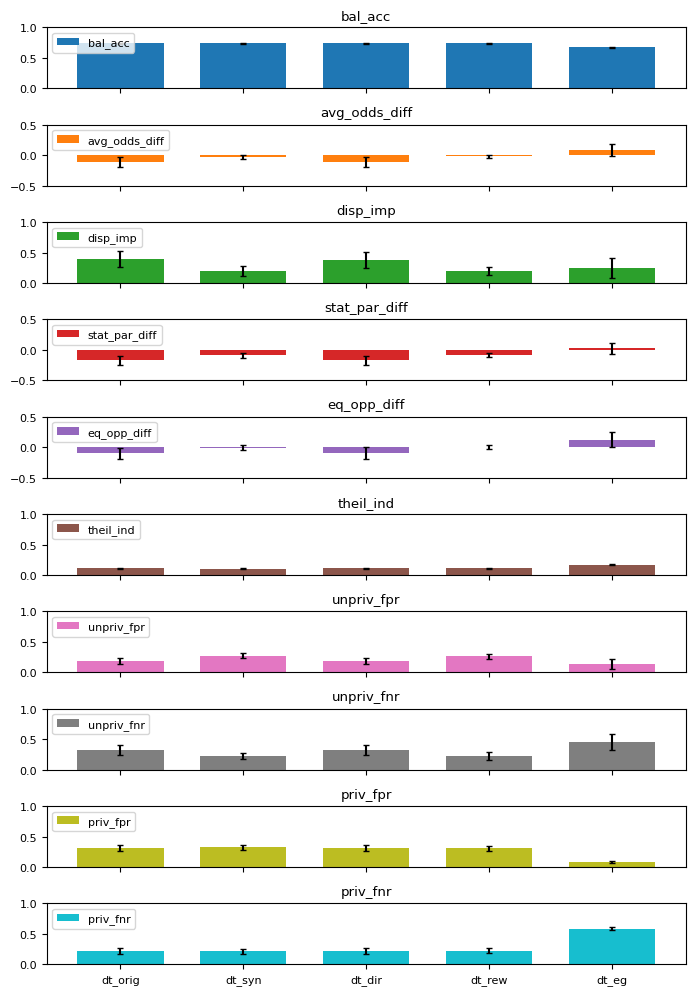

In [52]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [53]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./results/{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./results/mia2_adult_race_fairness_metrics_2024-12-30.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [54]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [55]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_privacy_risk  \
Classifier MIA Attacks                                    
orig                                           0.505123   
syn                                            0.505050   
dir                                            0.505123   
rew                                            0.505093   
eg                                             0.505285   

                        subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.514773   
syn                                                         0.512690   
dir                                                         0.515143   
rew                                                         0.513670   
eg                                                          0.513847   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.535154   
syn                                                         0.529404   
dir                                                         0.535154   
rew                                                         0.530816   
eg                                                          0.530477   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.505514   
syn                                                         0.505719   
dir                                                         0.505514   
rew                                                         0.506023   
eg                                                          0.506006   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.510120  
syn                                                         0.510292  
dir                                                         0.510120  
rew                                                         0.510615  
eg                                                          0.510303

In [56]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [57]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [58]:
df_groups

subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.514773   
syn                                                         0.512690   
dir                                                         0.515143   
rew                                                         0.513670   
eg                                                          0.513847   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.505514   
syn                                                         0.505719   
dir                                                         0.505514   
rew                                                         0.506023   
eg                                                          0.506006   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.535154   
syn                                                         0.529404   
dir                                                         0.535154   
rew                                                         0.530816   
eg                                                          0.530477   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.510120  
syn                                                         0.510292  
dir                                                         0.510120  
rew                                                         0.510615  
eg                                                          0.510303

<Axes: xlabel='Classifier MIA Attacks'>

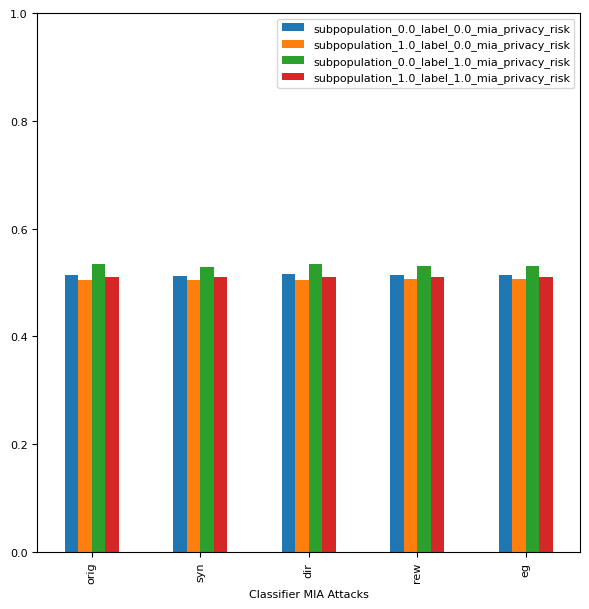

In [59]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [60]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.514773  0.51269   0.515143  0.51367   0.513847
subpopulation_1.0_label_0.0_mia_privacy_risk  0.505514  0.505719  0.505514  0.506023  0.506006
subpopulation_0.0_label_1.0_mia_privacy_risk  0.535154  0.529404  0.535154  0.530816  0.530477
subpopulation_1.0_label_1.0_mia_privacy_risk  0.51012   0.510292  0.51012   0.510615  0.510303


## Save Results

In [61]:
errors

[{'entire_dataset_mia_privacy_risk': 0.003079303596422639,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.012354464160417964,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.024692234387341545,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.0037203124193540414,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.006757875558713996},
 {'entire_dataset_mia_privacy_risk': 0.00258024747021105,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.010632409873219721,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.021696892960181215,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.003643969805391292,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.006489147086469786},
 {'entire_dataset_mia_privacy_risk': 0.003079303596422639,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.012326831846112623,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.024692234387341545,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.0037203124193540414,
  'subpopulation_1.0_label_1

In [62]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./results/{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./results/mia2_adult_race_mia_privacy_risks_metrics_2024-12-30.csv


# Main Bar Graph Visualization

In [63]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

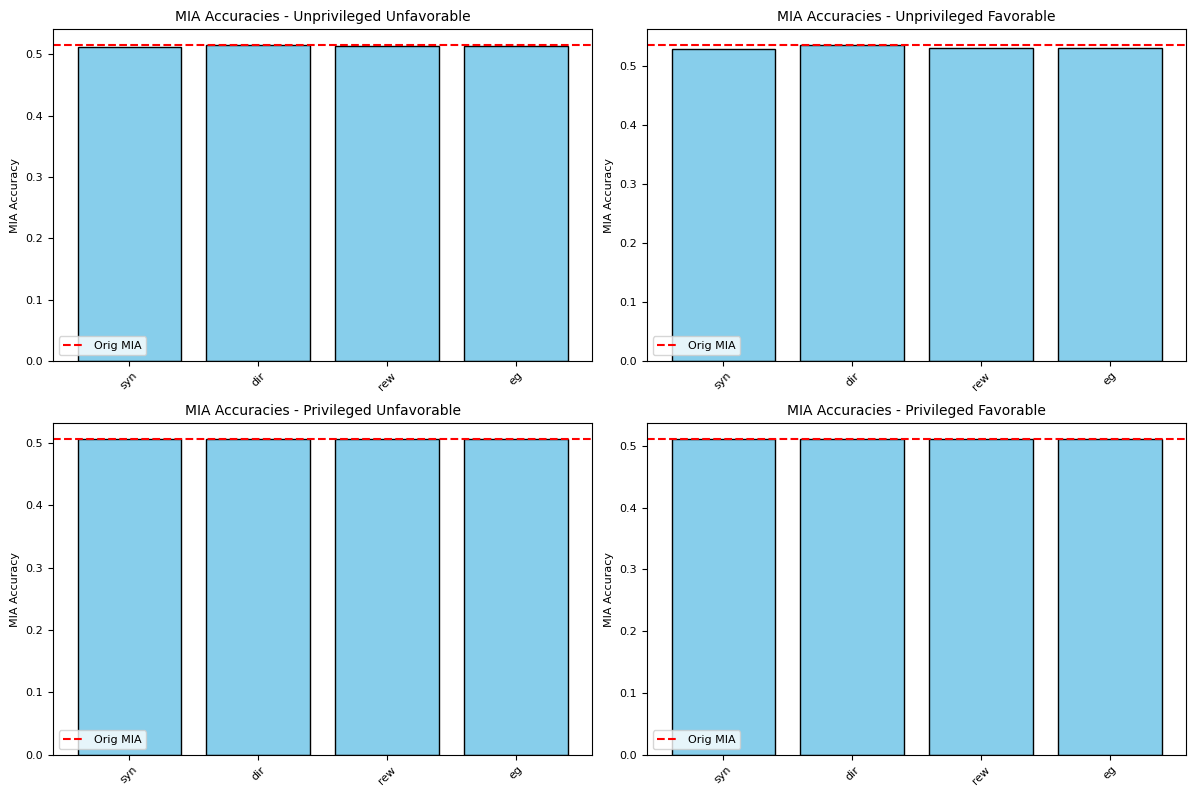

In [64]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [65]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [66]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [67]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.507763
1       orig               entire_dataset_mia_privacy_risk      0.501962
2       orig               entire_dataset_mia_privacy_risk      0.500768
3       orig               entire_dataset_mia_privacy_risk      0.503754
4       orig               entire_dataset_mia_privacy_risk      0.505972
..       ...                                           ...           ...
495       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.512249
496       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.504722
497       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.510847
498       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.500000
499       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.510700

[500 rows x 3 columns]

In [68]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.507763
1       orig               entire_dataset_mia_privacy_risk      0.501962
2       orig               entire_dataset_mia_privacy_risk      0.500768
3       orig               entire_dataset_mia_privacy_risk      0.503754
4       orig               entire_dataset_mia_privacy_risk      0.505972
..       ...                                           ...           ...
495       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.512249
496       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.504722
497       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.510847
498       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.500000
499       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.510700

[500 rows x 3 columns]

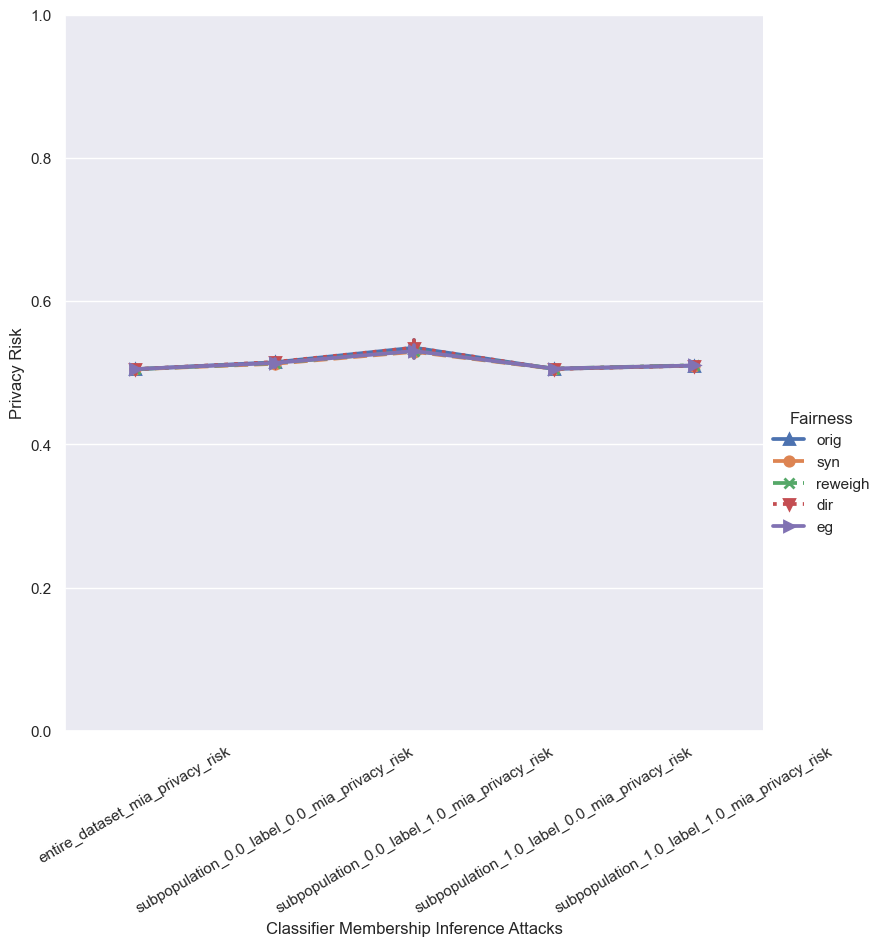

In [69]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [70]:
from sklearn.metrics import RocCurveDisplay, auc

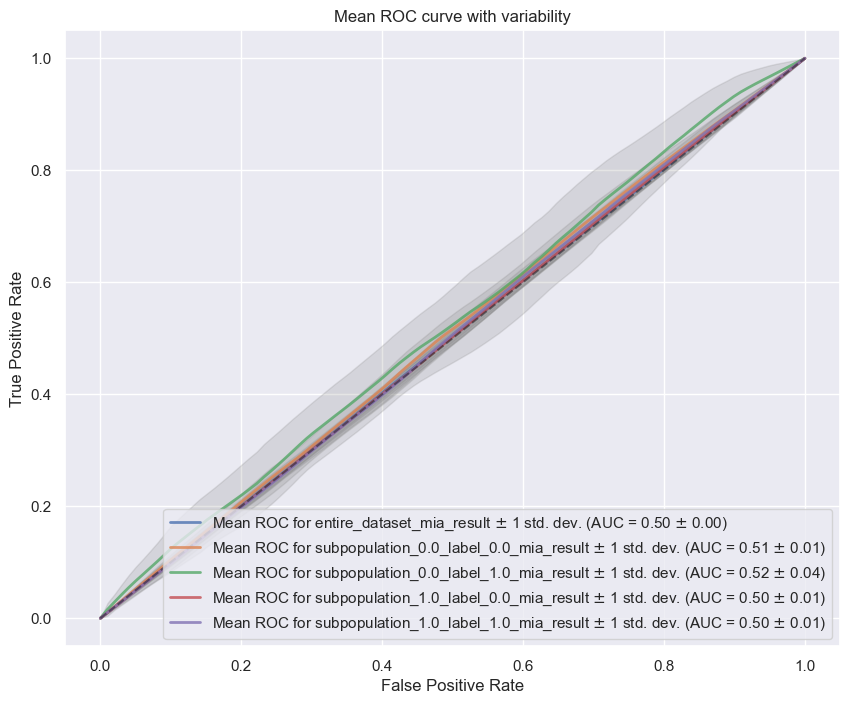

In [71]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: [0.30910451]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: [0.4567584]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: [0.52951776]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 5861, Test = 5861
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  T

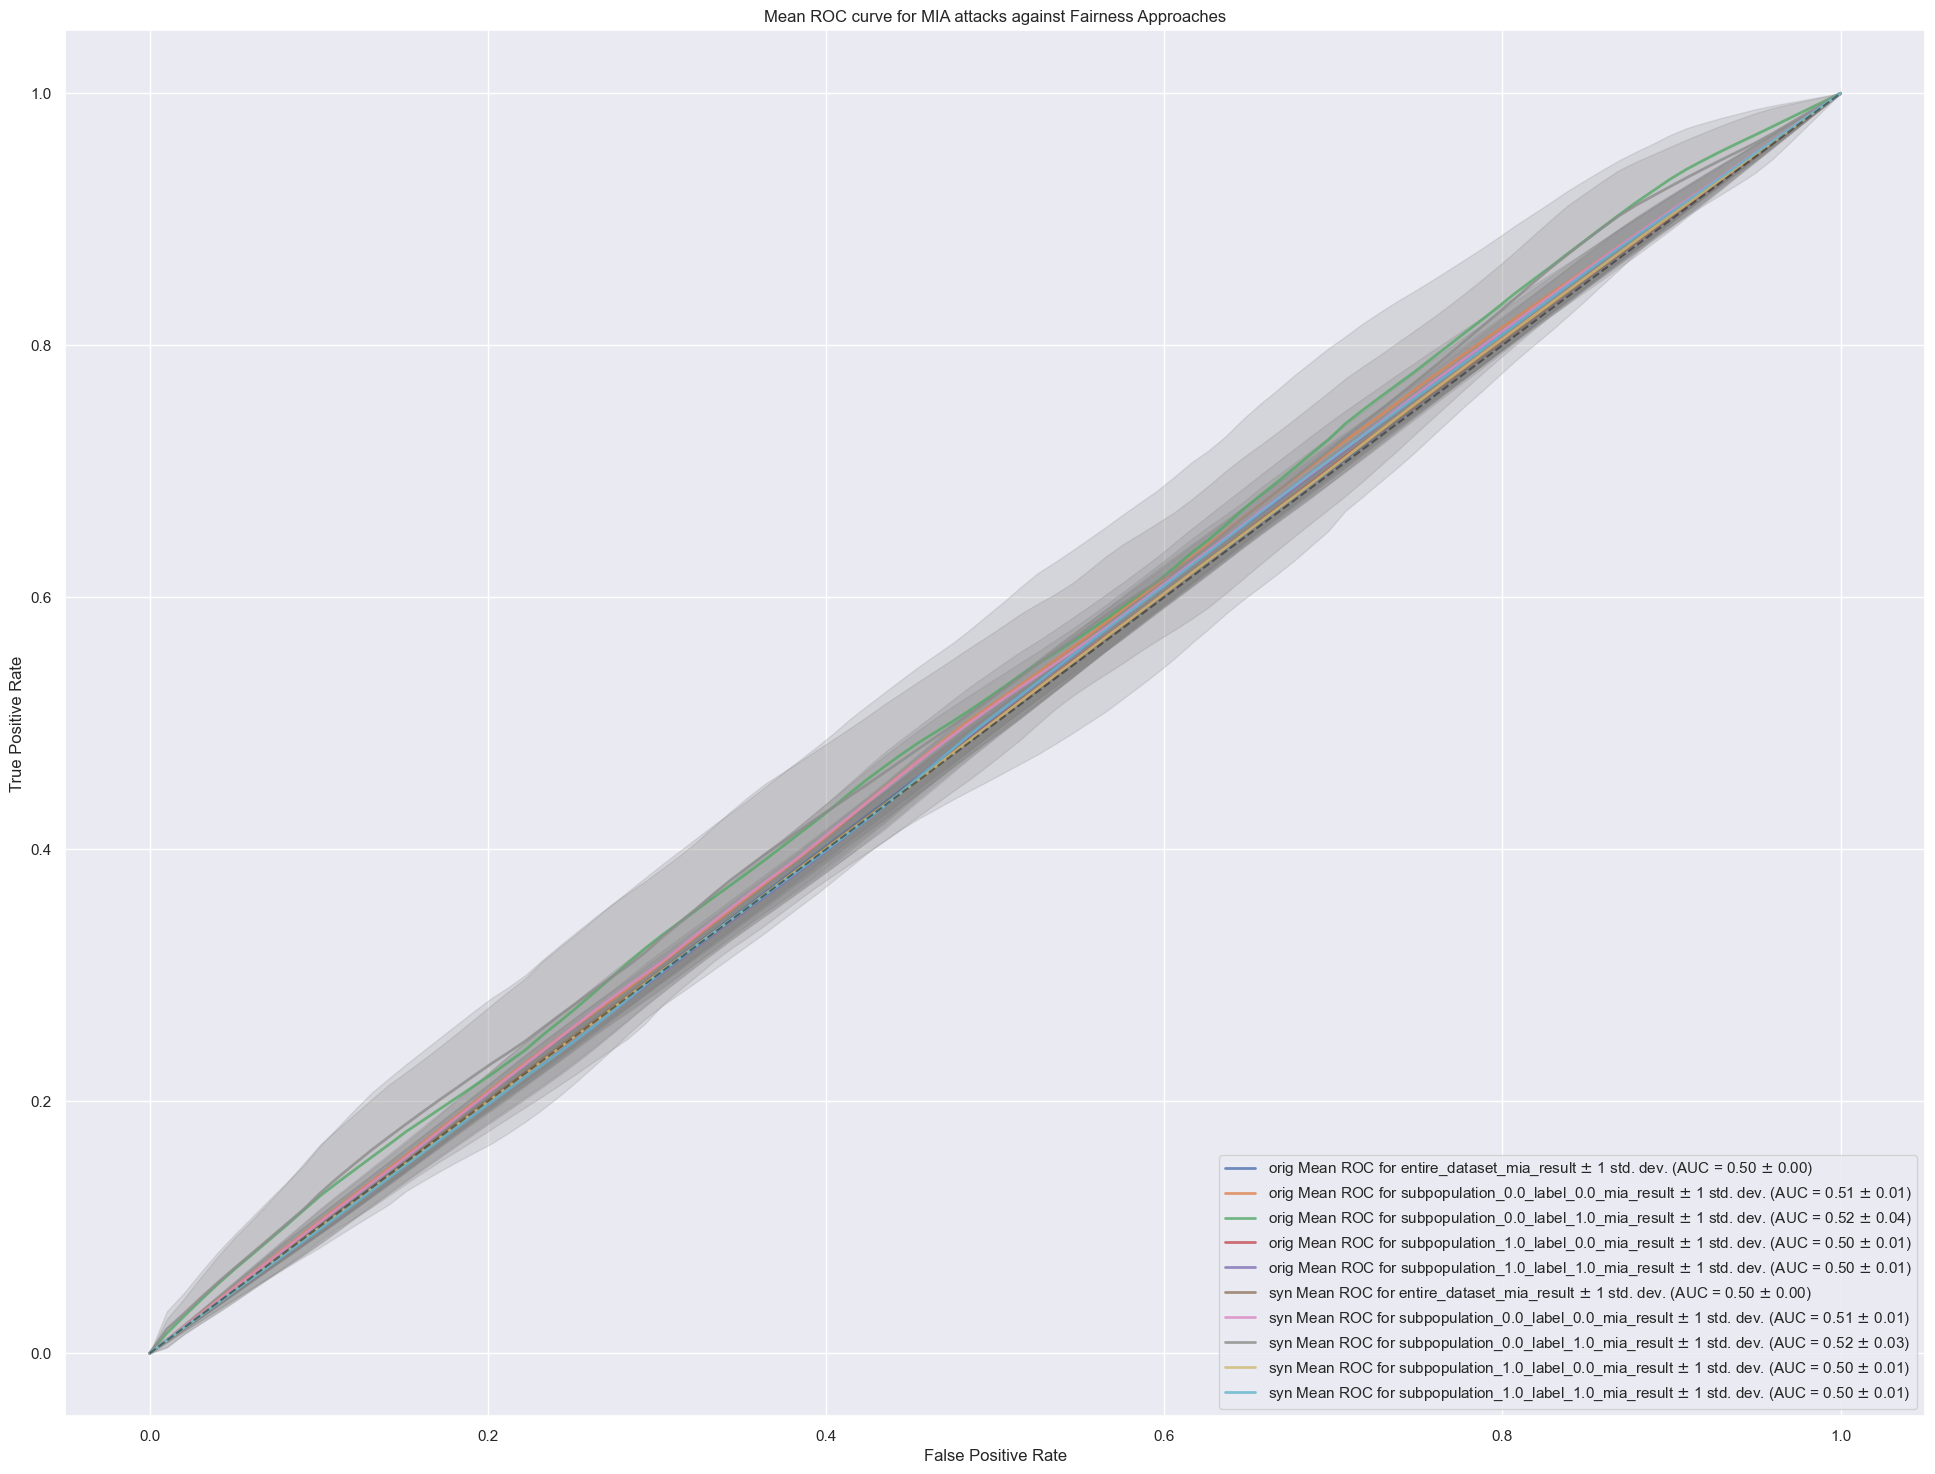

In [72]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

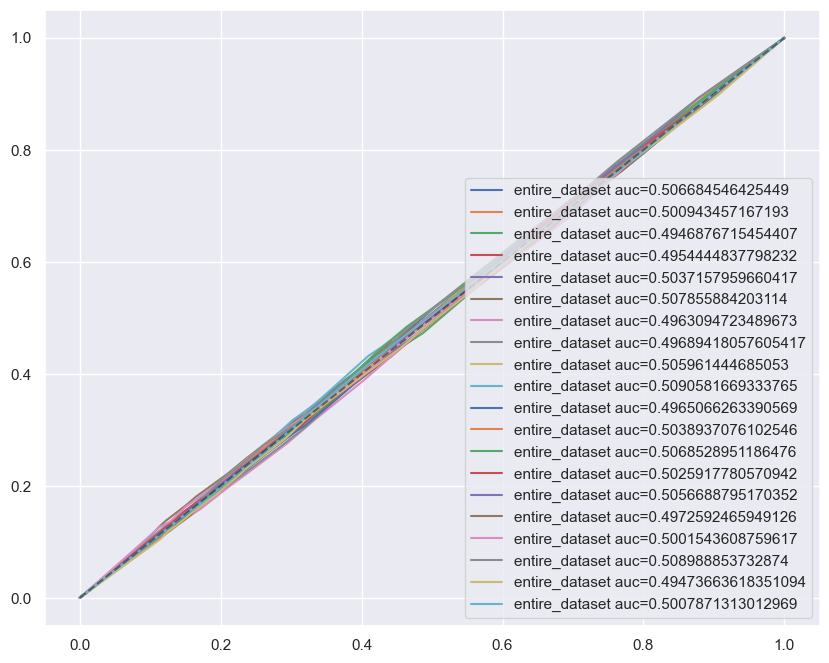

In [73]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [74]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [75]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_auc  \
Classifier MIA Attacks                           
orig                                  0.501750   
syn                                   0.501660   
dir                                   0.501774   
rew                                   0.501855   
egr                                   0.501667   

                        subpopulation_0.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.510017   
syn                                                0.508452   
dir                                                0.510009   
rew                                                0.509603   
egr                                                0.511528   

                        subpopulation_0.0_label_1.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.524203   
syn                                                0.523066   
dir                                                0.524421   
rew                                                0.521219   
egr                                                0.517604   

                        subpopulation_1.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.501589   
syn                                                0.501626   
dir                                                0.501598   
rew                                                0.501861   
egr                                                0.501683   

                        subpopulation_1.0_label_1.0_mia_auc  
Classifier MIA Attacks                                       
orig                                               0.503598  
syn                                                0.503532  
dir                                                0.503607  
rew                                                0.503385  
egr                                                0.503719

<Axes: xlabel='Classifier MIA Attacks'>

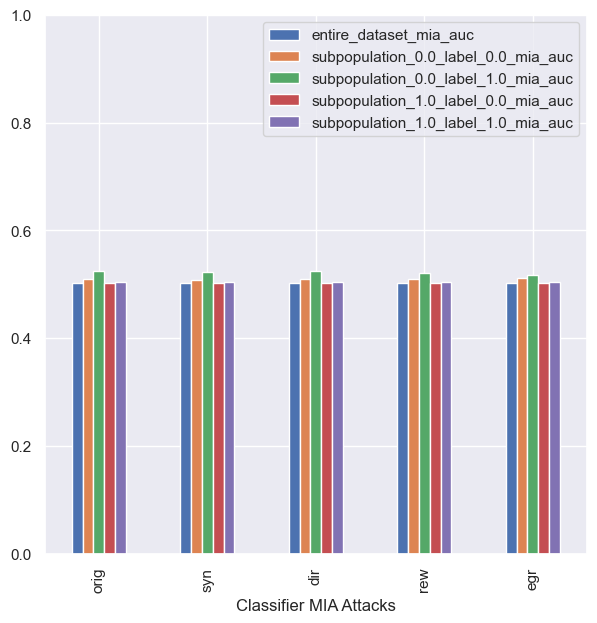

In [76]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [77]:
# Creating data structures to plot point categorical plot from seaborn

In [78]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [79]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.015526360689302132],
 ['orig', 'entire_dataset', 0.003924245009384042],
 ['orig', 'entire_dataset', 0.014332025251663494],
 ['orig', 'entire_dataset', 0.011772735028152237],
 ['orig', 'entire_dataset', 0.011943354376386273],
 ['orig', 'entire_dataset', 0.01569698003753625],
 ['orig', 'entire_dataset', 0.018426889609281683],
 ['orig', 'entire_dataset', 0.015526360689302132],
 ['orig', 'entire_dataset', 0.013137689814024966],
 ['orig', 'entire_dataset', 0.02235113461866578],
 ['orig', 'entire_dataset', 0.011943354376386273],
 ['orig', 'entire_dataset', 0.009554683501109051],
 ['orig', 'entire_dataset', 0.019962463743388503],
 ['orig', 'entire_dataset', 0.009725302849343143],
 ['orig', 'entire_dataset', 0.01433202525166355],
 ['orig', 'entire_dataset', 0.010066541545811297],
 ['orig', 'entire_dataset', 0.01518512199283406],
 ['orig', 'entire_dataset', 0.01603821873400446],
 ['orig', 'entire_dataset', 0.009554683501109024],
 ['orig', 'entire_dataset', 0.008360

In [80]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

Fairness                          MIA  attacker_advantage
0       orig               entire_dataset            0.015526
1       orig               entire_dataset            0.003924
2       orig               entire_dataset            0.014332
3       orig               entire_dataset            0.011773
4       orig               entire_dataset            0.011943
..       ...                          ...                 ...
495      egr  subpopulation_1.0_label_1.0            0.024497
496      egr  subpopulation_1.0_label_1.0            0.032925
497      egr  subpopulation_1.0_label_1.0            0.032348
498      egr  subpopulation_1.0_label_1.0            0.031749
499      egr  subpopulation_1.0_label_1.0            0.021401

[500 rows x 3 columns]

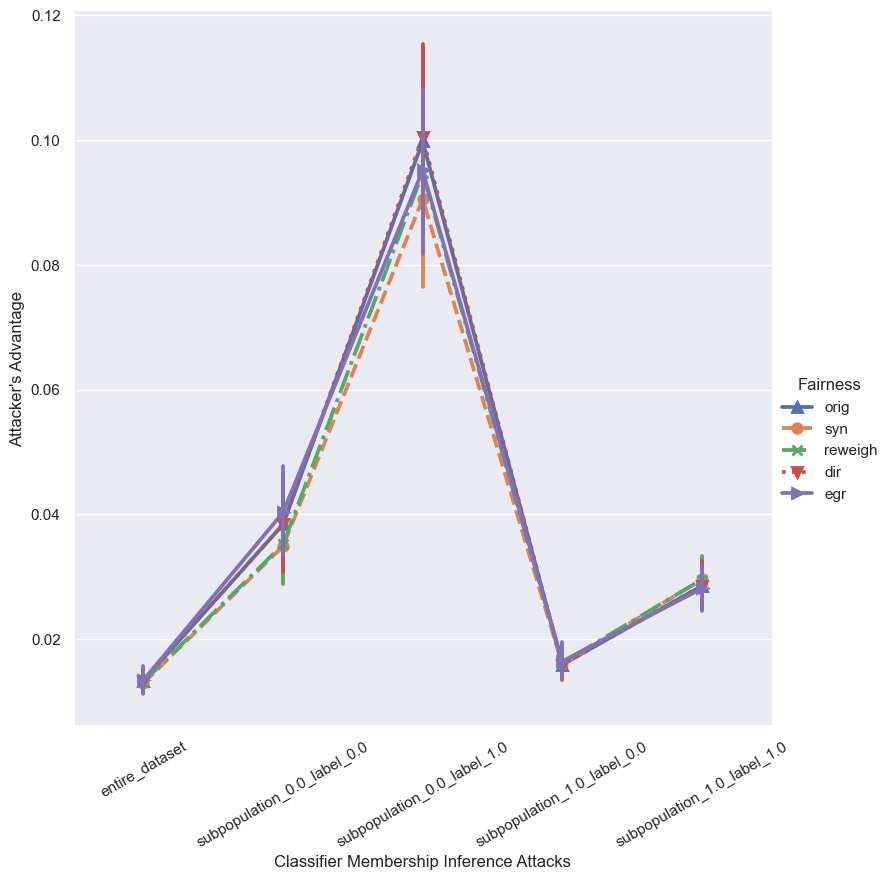

In [81]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


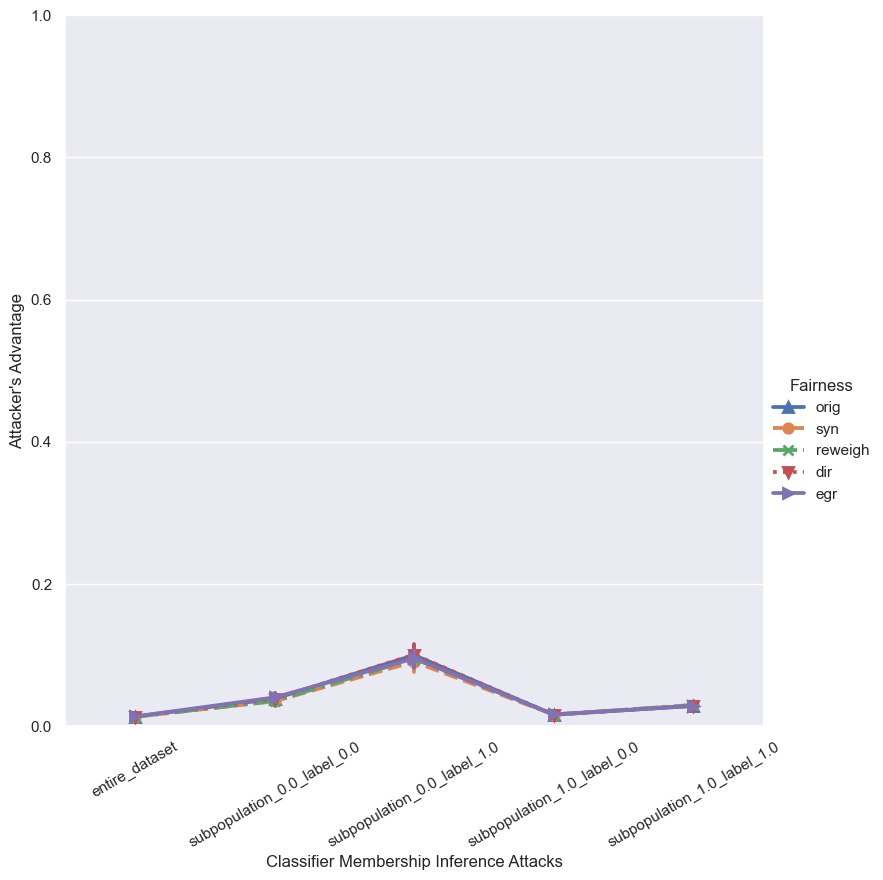

In [82]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [83]:
pd.DataFrame(orig_mia_metrics_att_ad)

entire_dataset_mia_attacker_advantage  \
0                                0.015526   
1                                0.003924   
2                                0.014332   
3                                0.011773   
4                                0.011943   
5                                0.015697   
6                                0.018427   
7                                0.015526   
8                                0.013138   
9                                0.022351   
10                               0.011943   
11                               0.009555   
12                               0.019962   
13                               0.009725   
14                               0.014332   
15                               0.010067   
16                               0.015185   
17                               0.016038   
18                               0.009555   
19                               0.008360   

    subpopulation_0.0_label_0.0_mia_attacker_advantage  \
0                                            0.031655    
1                                            0.020720    
2                                            0.037133    
3                                            0.032140    
4                                            0.061027    
5                                            0.045478    
6                                            0.032300    
7                                            0.046857    
8                                            0.033174    
9                                            0.064587    
10                                           0.028654    
11                                           0.012631    
12                                           0.023814    
13                                           0.028250    
14                                           0.032009    
15                                           0.083543    
16                                           0.052945    
17                                           0.064475    
18                                           0.015485    
19                                           0.021193    

    subpopulation_0.0_label_1.0_mia_attacker_advantage  \
0                                            0.112309    
1                                            0.100570    
2                                            0.117299    
3                                            0.118636    
4                                            0.040675    
5                                            0.098221    
6                                            0.074402    
7                                            0.195571    
8                                            0.084231    
9                                            0.115451    
10                                           0.136341    
11                                           0.100726    
12                                           0.106337    
13                                           0.123266    
14                                           0.048654    
15                                           0.092925    
16                                           0.068839    
17                                           0.060606    
18                                           0.101712    
19                                           0.099265    

    subpopulation_1.0_label_0.0_mia_attacker_advantage  \
0                                            0.009392    
1                                            0.009497    
2                                            0.011853    
3                                            0.012502    
4                                            0.016560    
5                                            0.022272    
6                                            0.030558    
7                                            0.024393    
8                                            0.013762    
9                                       

In [84]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [85]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_attacker_advantage  \
Classifier MIA Attacks                                          
orig                                                 0.013368   
syn                                                  0.012941   
dir                                                  0.013368   
rew                                                  0.013155   
egr                                                  0.013453   

                        subpopulation_0.0_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.038403    
syn                                                              0.034919    
dir                                                              0.038403    
rew                                                              0.035200    
egr                                                              0.040309    

                        subpopulation_0.0_label_1.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.099802    
syn                                                              0.090532    
dir                                                              0.100450    
rew                                                              0.094677    
egr                                                              0.095135    

                        subpopulation_1.0_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.015897    
syn                                                              0.015955    
dir                                                              0.015897    
rew                                                              0.016199    
egr                                                              0.016444    

                        subpopulation_1.0_label_1.0_mia_attacker_advantage  
Classifier MIA Attacks                                                      
orig                                                             0.028537   
syn                                                              0.029570   
dir                                                              0.028591   
rew                                                              0.029559   
egr                                                              0.028124

<Axes: xlabel='Classifier MIA Attacks'>

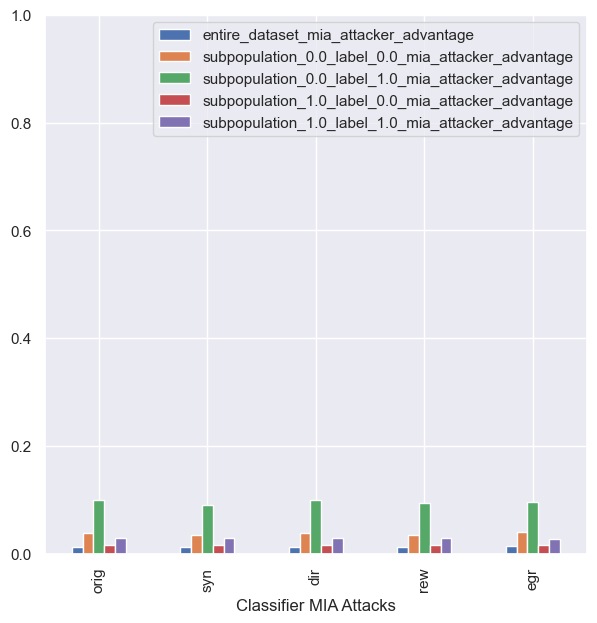

In [86]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [87]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [88]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5097048657272002],
 ['orig', 'entire_dataset', 0.502039230918625],
 ['orig', 'entire_dataset', 0.5005495176456222],
 ['orig', 'entire_dataset', 0.5146862483311082],
 ['orig', 'entire_dataset', 0.5088495575221239],
 ['orig', 'entire_dataset', 0.5298752462245568],
 ['orig', 'entire_dataset', 0.5022286471509456],
 ['orig', 'entire_dataset', 0.5029709891646278],
 ['orig', 'entire_dataset', 0.5089869281045751],
 ['orig', 'entire_dataset', 0.5140264026402641],
 ['orig', 'entire_dataset', 0.5022691033975224],
 ['orig', 'entire_dataset', 0.5062277580071174],
 ['orig', 'entire_dataset', 0.5105386416861827],
 ['orig', 'entire_dataset', 0.5104815864022663],
 ['orig', 'entire_dataset', 0.5053995680345572],
 ['orig', 'entire_dataset', 0.5004502070952638],
 ['orig', 'entire_dataset', 0.5275196568977841],
 ['orig', 'entire_dataset', 0.511963696369637],
 ['orig', 'entire_dataset', 0.5],
 ['orig', 'entire_dataset', 0.5049167168372466],
 ['orig', 'subpopulation_0.0_label_0.

In [89]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

Fairness                          MIA       PPV
0       orig               entire_dataset  0.509705
1       orig               entire_dataset  0.502039
2       orig               entire_dataset  0.500550
3       orig               entire_dataset  0.514686
4       orig               entire_dataset  0.508850
..       ...                          ...       ...
495      egr  subpopulation_1.0_label_1.0  0.527441
496      egr  subpopulation_1.0_label_1.0  0.506296
497      egr  subpopulation_1.0_label_1.0  0.515498
498      egr  subpopulation_1.0_label_1.0  0.527809
499      egr  subpopulation_1.0_label_1.0  0.507666

[500 rows x 3 columns]

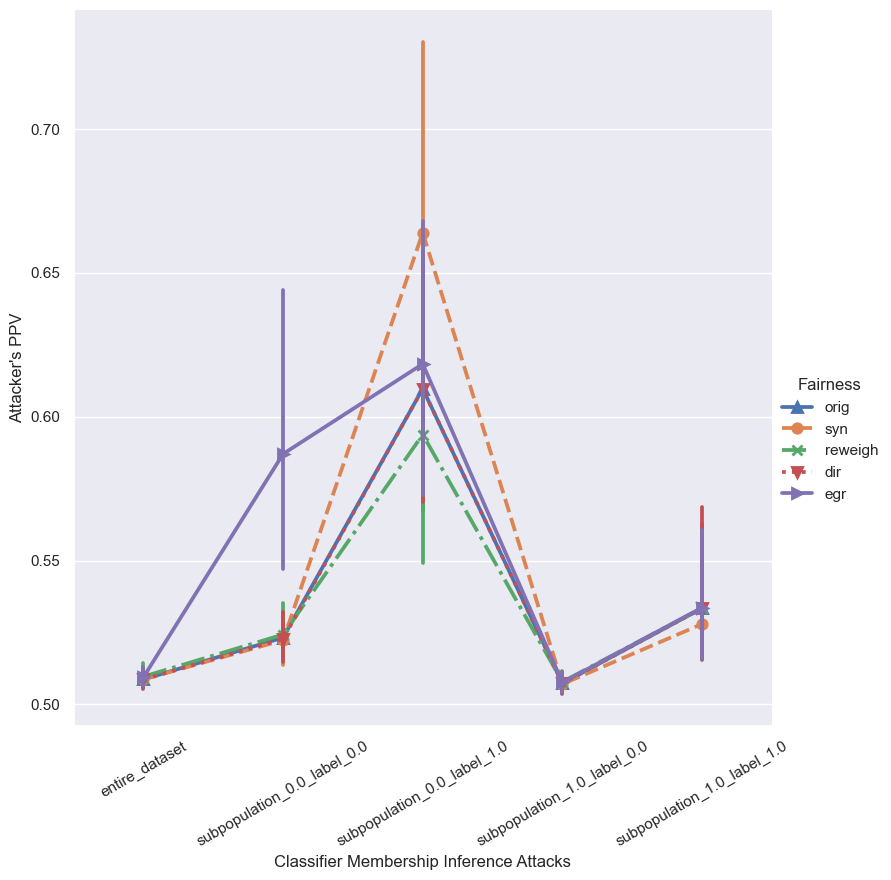

In [90]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
